In [ ]:
#data_analysis env
import pygam
from pygam import LinearGAM, s, f
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import shap

#segoeui font
plt.rcParams['font.family'] = 'Segoe UI'

#### Inputs

In [2]:
src_meteo = r"D:\VUB\_data\_isimip_3b\model_outputs\meteo"
src_recharge = r"D:\VUB\_data\_isimip_3b\model_outputs\mHM_Gr_Fluxes_L2"
models = ['GFDL-ESM4', 'IPSL-CM6A-LR', 'MPI-ESM1-2-HR', 'UKESM1-0-LL']
meteo_vars = ['pre', 'pet']
scenarios = ['historical', 'ssp585']

In [3]:
def da_to_dict(src, models, scenarios, variables):
    data_dict = {}
    for model in models:
        for scenario in scenarios:
            for variable in variables:
                file_path = f"{src}/{model}/{scenario}/{variable}.nc"
                ds = xr.open_dataset(file_path)
                if variable == 'recharge_L2':
                    da = ds[['recharge']]
                else:
                    da = ds[[variable]]
                key = f"{model}_{scenario}_{variable}"
                data_dict[key] = da
    return data_dict

In [4]:
#stack models on keys
def stack_models(meteo_dict, model_keys):
    stacked_models_meteo = []

    for key in model_keys:
        model_da = meteo_dict[key].assign_coords(model=key.split("_")[0])
        model_da = model_da.expand_dims("model")
        stacked_models_meteo.append(model_da)

    da = xr.concat(stacked_models_meteo, dim="model")
    return da

In [5]:
def compute_mon_deltas(hydro_dict, var, hist_slice, fut_slice, agg='sum'):
    """
    Return future monthly anomalies (future minus historical monthly climatology).
    Assumes daily data; set agg='mean' if inputs are daily means you want monthly means.
    """
    da_hist = hydro_dict[f'historical_{var}'].sel(time=hist_slice)
    da_fut  = hydro_dict[f'ssp585_{var}'].sel(time=fut_slice)

    # monthly aggregates
    hist_mon = getattr(da_hist.resample(time='ME'), agg)()
    fut_mon  = getattr(da_fut .resample(time='ME'), agg)()

    # historical monthly climatology (1..12)
    hist_mon_clim = hist_mon.groupby('time.month').mean('time')

    # anomalies for each future month (retain future time axis)
    fut_mon_anom = fut_mon.groupby('time.month') - hist_mon_clim

    # optional rename for recharge
    if var == 'mHM_Gr_Fluxes':
        fut_mon_anom = fut_mon_anom.rename({'recharge_L2': 'recharge'})

    return fut_mon_anom  # dims: time (monthly in future window), y, x


In [6]:
def ens_stats(models_dict, scenarios, vars_list):
    stats_dict = {}
    for scenario in scenarios:
        for variable in vars_list:
            stacked_models = stack_models(models_dict, [key for key in models_dict.keys() if scenario in key and variable in key])

            #compute ensemble mean
            ens_mean = stacked_models.mean(dim='model')
            stats_dict[f"{scenario}_{variable}"] = ens_mean
    return stats_dict

#### Compute ensemble statistics

In [7]:
#Group data into dictionaries
meteo_dict = da_to_dict(src_meteo, models, scenarios, meteo_vars)
recharge_dict = da_to_dict(src_recharge, models, scenarios, ['recharge_L2'])

#Compute ensemble means
ens_meteo_mean = ens_stats(meteo_dict, scenarios, meteo_vars)
ens_recharge_mean = ens_stats(recharge_dict, scenarios, ['recharge_L2'])
#replace recharge_L2 key with recharge
ens_recharge_mean = {key.replace('recharge_L2', 'recharge'): value for key, value in ens_recharge_mean.items()}

In [8]:
#calculate water availability (p-pet) per scenario
water_availability = {}
for scenario in scenarios:
    pre = ens_meteo_mean[f"{scenario}_pre"]
    pet = ens_meteo_mean[f"{scenario}_pet"]
    wa = pre['pre'] - pet['pet']
    #wa to dataset
    wa = wa.to_dataset(name='wa')
    water_availability[f"{scenario}_wa"] = wa

#### Compute future changes

In [9]:
#resample to monthly and calculate changes
hist_time_slice = slice('1981-01-01', '2010-12-31')
fut_time_slice = slice('2071-01-01', '2100-12-31')

pre_delta = compute_mon_deltas(ens_meteo_mean, 'pre', hist_time_slice, fut_time_slice)
pet_delta = compute_mon_deltas(ens_meteo_mean, 'pet', hist_time_slice, fut_time_slice)
wa_delta = compute_mon_deltas(water_availability, 'wa', hist_time_slice, fut_time_slice)
recharge_delta = compute_mon_deltas(ens_recharge_mean, 'recharge', hist_time_slice, fut_time_slice)

#### Extract timeseries of features

Extract timeseries for different soil regions: Campine (Sand), Loess (Loam), Ardennes (Sandy Loam)

In [10]:
#Soil regions of interest
region_names = ['Ardennen','Campine', 'Loess Region',
                'Campine_L', 'Ardennen_L', 'Loess_L']

#create df of regions and their coordinates (these are subsets of the regions not the entire regions)
roi_df = pd.DataFrame(index=region_names, columns=['min_lon','min_lat','max_lon','max_lat'])
roi_df.loc['Ardennen'] = [5.20, 49.90, 5.7, 50.4]
roi_df.loc['Campine'] = [4.45,50.90, 5.50, 51.40]
roi_df.loc['Loess Region'] = [4.6, 50.5, 5.2, 50.9]
roi_df.loc['Campine_L'] = [4.47,51.04,5.67, 51.45]
roi_df.loc['Ardennen_L'] = [5.127, 49.90, 6.14, 50.515]
roi_df.loc['Loess_L'] = [3.466, 50.479, 4.196, 50.907]


dx = 0.0625
dy = 0.0625

#for each roi, extract several timeseries based on dx, dy. average over pixels within dx, dy
roi_df.reset_index(inplace=True)
roi_df.rename(columns={'index':'name'}, inplace=True)

In [11]:
roi_df

,name,min_lon,min_lat,max_lon,max_lat
0,Ardennen,5.2,49.9,5.7,50.4
1,Campine,4.45,50.9,5.5,51.4
2,Loess Region,4.6,50.5,5.2,50.9
3,Campine_L,4.47,51.04,5.67,51.45
4,Ardennen_L,5.127,49.9,6.14,50.515
5,Loess_L,3.466,50.479,4.196,50.907


In [12]:
#for each roi, extract several timeseries based on dx, dy. average over pixels within dx, dy and store each in a dict
bbox_dict = {}
for index, row in roi_df.iterrows():
    name = row['name']
    min_lon = row['min_lon']
    min_lat = row['min_lat']
    max_lon = row['max_lon']
    max_lat = row['max_lat']

    #lon/lat ranges with dx, dy
    lat_range = np.arange(min_lat, max_lat+dy, dy)
    lon_range = np.arange(min_lon, max_lon+dx, dx)
    bbox_dict[name] = {'lat': lat_range, 'lon': lon_range}

In [13]:
def extract_roi_timeseries(da, bbox_dict, region_name='all'):
    """
    Extract seasonal time series from one or all regions.

    Parameters
    ----------
    da : xr.DataArray
        DataArray with dimensions including 'time', 'lat', 'lon'.
    bbox_dict : dict
        Dict of {region_name: {'lat': lat_array, 'lon': lon_array}}.
    region_name : str, optional
        'all' for all regions, or a specific region key in bbox_dict.

    Returns
    -------
    pd.DataFrame
        Long DataFrame with seasonal time series stacked for tiles/regions.
    """
    da_df_list = []

    # Decide which regions to loop over
    if region_name == 'all':
        region_keys = bbox_dict.keys()
    elif region_name in bbox_dict:
        region_keys = [region_name]
    else:
        raise ValueError(f"region_name '{region_name}' not in bbox_dict and not 'all'.")

    for reg in region_keys:
        bbox = bbox_dict[reg]
        lat_range = bbox['lat']
        lon_range = bbox['lon']

        for i in range(len(lon_range) - 1):
            lon_min = lon_range[i]
            lon_max = lon_range[i + 1]

            for j in range(len(lat_range) - 1):
                lat_min = lat_range[j]
                lat_max = lat_range[j + 1]

                # Half-open box: [lon_min, lon_max), [lat_min, lat_max)
                da_subset = da.where(
                    (da.lon >= lon_min) & (da.lon < lon_max) &
                    (da.lat >= lat_min) & (da.lat < lat_max),
                    drop=True
                )


                # Mean over space
                da_df = da_subset.mean(dim=['lat', 'lon']).to_dataframe()

                # Drop 'month' if present
                da_df = da_df.drop(columns=['month'], errors='ignore')

                # Skip if there are NaNs
                if da_df.isnull().values.any():
                    continue

                # Seasonal aggregation (QS-DEC)
                da_df = da_df.resample('QS-DEC').sum()

                # Add region info
                da_df['roi'] = reg

                da_df_list.append(da_df)

    if not da_df_list:
        # Nothing found; decide what you prefer here
        return None

    # Stack all tiles/regions end-to-end
    da_df = pd.concat(da_df_list, axis=0)

    # Optional: reset index so 'time' is a column
    da_df = da_df.reset_index().rename(columns={'index': 'time'})
    return da_df

#### Data Driven Model for Recharge change

In [14]:
#Extract timeseries for regions
da_ROI_dict = {}
for da in [recharge_delta, pre_delta, pet_delta, wa_delta]:
    da_ROI = extract_roi_timeseries(da, bbox_dict, region_name='all')
    #set index to time
    da_ROI.set_index('time', inplace=True)
    #extract variable name
    da_name = list(da.data_vars)[0]
    da_ROI_dict[da_name] = da_ROI

#Convert dictionary to dataframe
#recharge comes from a higher resolution da so it will have more grids than the others
df_regions = pd.DataFrame({
    'wa': da_ROI_dict['wa']['wa'].values,
    'pet': da_ROI_dict['pet']['pet'].values,
    'pre': da_ROI_dict['pre']['pre'].values,
    'recharge': da_ROI_dict['recharge']['recharge'],
    'roi': da_ROI_dict['wa']['roi'].values
})

#index to datetime
df_regions.index = pd.to_datetime(da_ROI_dict['wa'].index)

#separate the dataframe into seasonal data
seasons = {
    'summer': [6],
    'autumn': [9],
    'winter': [12],
    'spring': [3]
    }
#add season column based on month
df_regions['season'] = df_regions.index.month.map(lambda x: next((season for season, months in seasons.items() if x in months), None))

#QS-DEC generates 1 more extra winter season
df_regions = df_regions[(df_regions.index.year >= 2071) & (df_regions.index.year <= 2100)]

In [15]:
#lag wa by one season
def extract_season_df(df_regions, season):
    """
    Extract seasonal DataFrame with lagged water availability.
    """
    if season == 'summer':
        df_season = df_regions[df_regions['season'] == season]
        df_lag = df_regions[df_regions['season'] == 'spring']['wa'].values
        df_season = df_season.copy()
        df_season.loc[:, 'wa_lag1'] = df_lag
    elif season == 'autumn':
        df_season = df_regions[df_regions['season'] == season]
        df_lag = df_regions[df_regions['season'] == 'summer']['wa'].values
        df_season = df_season.copy()
        df_season.loc[:, 'wa_lag1'] = df_lag
    elif season == 'winter':
        df_season = df_regions[df_regions['season'] == season]
        df_lag = df_regions[df_regions['season'] == 'autumn']['wa'].values
        df_season = df_season.copy()
        df_season.loc[:, 'wa_lag1'] = df_lag
    elif season == 'spring':
        df_season = df_regions[df_regions['season'] == season]
        #winter lag is different since the first winter is at end of the current year. so it is before spring. we need to shift by one
        df_lag = df_regions[df_regions['season'] == 'winter']['wa'].shift(1).values
        df_season = df_season.copy()
        df_season.loc[:, 'wa_lag1'] = df_lag
        df_season.dropna(inplace=True)

    return df_season

In [16]:
df_summer = extract_season_df(df_regions, 'summer')
df_spring = extract_season_df(df_regions, 'spring')
df_winter = extract_season_df(df_regions, 'winter')
df_autumn = extract_season_df(df_regions, 'autumn')

In [19]:
# #Build GAM model
# X = ds_spring[['pet', 'pre', 'wa_lag1']].values
# y = ds_spring['recharge'].values

# # fit (use gridsearch so smoothness is tuned)
# gam = LinearGAM(s(0) + s(1) + s(2)).fit(X, y)

# # 1-D partials for pet, pre, wa_lag1  (terms 0,1,3)
# titles = ['ΔPET', 'ΔP', 'lagged Δ(P−PET)']
# fig, axs = plt.subplots(1, 3, figsize=(14,4), constrained_layout=True)
# for i, ax in enumerate(axs):
#     XX = gam.generate_X_grid(term=i)
#     ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
#     ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
#     #add scatter points
#     ax.scatter(X[:, i], y, alpha=0.3)
#     if i == 0:
#         ax.set_ylim(-30,30)
#     ax.set_title(titles[i]);

#### RF for seasonal recharge

In [20]:
def rF_emulator(df_regions, region_names):
    """
    Build Random Forest emulator for seasonal recharge attribution.

    Parameters
    ----------
    df_regions : pd.DataFrame
        DataFrame containing columns 'wa', 'pet', 'pre', 'recharge', 'roi' and 'season'.
    region_names : list of str
        All regions, or a specific region name in 'roi' column.
    Returns
    -------
    dict
        Dictionary containing trained Random Forest models for each season.

    """
    df_regions = df_regions[df_regions['roi'].isin(region_names)]

    seasonal_emulators = {}

    for season in df_regions['season'].unique():

        df_season = extract_season_df(df_regions, season)

        #Add lagged water availability
        df_season = df_season.copy()
        X = df_season[['pet', 'pre', 'wa_lag1']].values
        y = df_season['recharge'].values

        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

        param_grid = {
            'n_estimators': [200],        # Number of trees in the forest
            'max_depth': [40],              # Maximum depth of each tree
            'min_samples_split': [3],        # Minimum number of samples required to split an internal node
            'min_samples_leaf': [2],         # Minimum number of samples required to be at a leaf node
            'max_features': ['sqrt', 'log2', None]  # Number of features to consider at each split
        }

        grid_search = GridSearchCV(
            estimator=RandomForestRegressor(),
            param_grid=param_grid,
            cv=5,                        # Number of cross-validation folds
            n_jobs=-1,                   # Number of jobs to run in parallel
            scoring='neg_mean_squared_error' # Strategy to evaluate the performance of the cross-validated model on the test set.
        )

        # Fit the model
        grid_search.fit(X_train, y_train)

        best_params = grid_search.best_params_
        best_model = grid_search.best_estimator_

        print(f"Best parameters: {best_params}")

        # Make predictions with the best model
        y_pred = best_model.predict(X_test)

        # Calculate the performance metrics
        # mse = mean_squared_error(y_test, y_pred)
        # rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)
        nse = 1 - (np.sum((y_test - y_pred)**2) / np.sum((y_test - y_test.mean())**2))

        seasonal_emulators[season] = {
            'model': best_model,
            'y_pred': y_pred,
            'y_test': y_test,
            'r2': r2,
            'nse': nse
        }

    return seasonal_emulators

In [66]:
df_regions

,wa,pet,pre,recharge,roi,season
time,,,,,,
2071-03-01,-66.815061,47.110671,-19.704380,-8.372171,Ardennen,spring
2071-06-01,-85.366745,73.061213,-12.305550,-12.341031,Ardennen,summer
2071-09-01,15.241699,19.526477,34.768173,-7.058814,Ardennen,autumn
2071-12-01,-13.168990,6.712507,-6.456490,-11.317533,Ardennen,winter
2072-03-01,24.483629,36.120031,60.603676,10.982066,Ardennen,spring
...,...,...,...,...,...,...
2099-12-01,125.445269,9.342412,134.787689,17.150273,Loess_L,winter
2100-03-01,-40.244391,42.865836,2.621449,-1.055633,Loess_L,spring
2100-06-01,-129.437649,91.647932,-37.789707,-10.444502,Loess_L,summer


In [ ]:
region_names = ['Ardennen', 'Ardennen_L', ]  # or subset
seasonal_emulators = rF_emulator(df_regions, region_names)


Best parameters: {'max_depth': 40, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 200}
Best parameters: {'max_depth': 40, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 200}
Best parameters: {'max_depth': 40, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 200}
Best parameters: {'max_depth': 40, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 200}


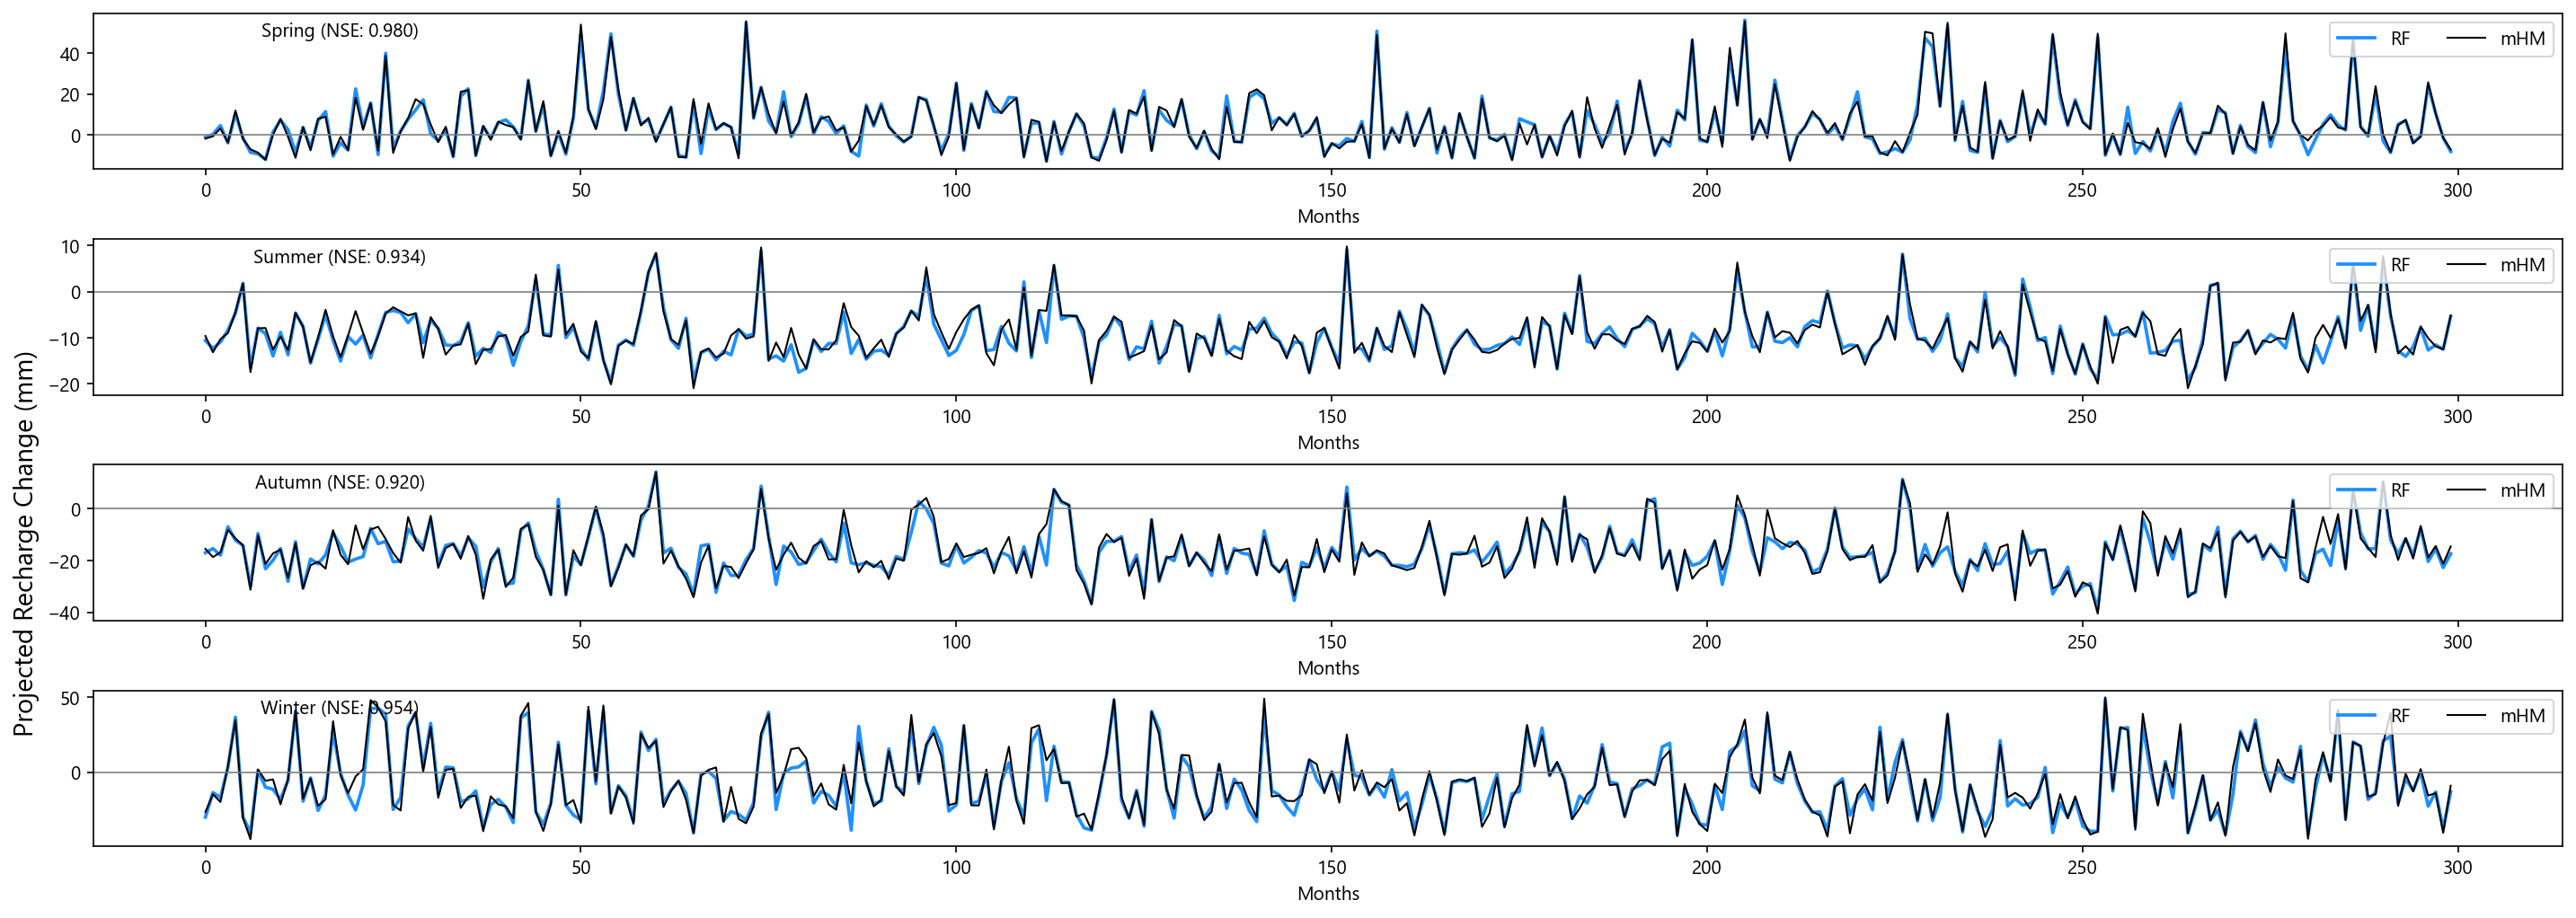

In [106]:
#plot the results vs the observed values
fig, ax = plt.subplots(4, 1, figsize=(19, 6.7), dpi=150, constrained_layout=True)
#add ax spacing

for season, results in seasonal_emulators.items():
    y_pred = results['y_pred']
    y_test = results['y_test']
    nse = results['nse']
    #plot in the corresponding subplot
    ax_idx = list(seasonal_emulators.keys()).index(season)
    plt.sca(ax[ax_idx])
    plt.plot(y_pred[400:700], color='dodgerblue', lw=1.8, label='RF')
    plt.plot(y_test[400:700], color='k', lw=1.0, label='mHM')
    plt.axhline(0, color='gray', lw=0.8)
    plt.text(0.1, 0.85, f"{season.capitalize()} (NSE: {nse:.3f})", transform=plt.gca().transAxes, ha='center')
    plt.xlabel('Months')
    #label y-axis for the middle plots only
    if ax_idx == 2:
        plt.ylabel('Projected Recharge Change (mm)', fontsize=14)
    plt.legend(ncol=2, loc='upper right')

In [107]:
feature_names = ['pet', 'pre', 'wa_lag1']

# How many samples per season to use for SHAP
N_SHAP = 1200  # you can try 500, 1000, etc.

shap_vals_dict = {}

seasonal_bucket_importance = {}

for season, results in seasonal_emulators.items():
    best_model = results['model']

    # Use the same df_season you used to train, if you stored it
    # If not, fall back to your current function
    if 'df_season' in results:
        df_season = results['df_season'].copy()
    else:
        df_season = extract_season_df(df_regions, season).copy()

    # Make sure wa_lag1 exists
    if 'wa_lag1' not in df_season.columns:
        raise ValueError(f"wa_lag1 missing for season {season}")

    X_full = df_season[['pet', 'pre', 'wa_lag1']].values

    # Skip if nothing to explain
    if X_full.shape[0] == 0:
        print(f"No samples for season {season}, skipping.")
        continue

    # ---- 1) Subsample rows for SHAP ----
    n_samples = min(N_SHAP, X_full.shape[0])
    # random subset of indices
    idx = np.random.choice(X_full.shape[0], size=n_samples, replace=False)
    X = X_full[idx, :]

    # ---- 2) Build explainer once and disable additivity check ----
    explainer = shap.TreeExplainer(best_model)
    shap_values = explainer.shap_values(X, check_additivity=False)

    if isinstance(shap_values, list):
        shap_values = shap_values[0]

    # Mean absolute SHAP (mm of recharge) and importance share
    mean_abs = np.mean(np.abs(shap_values), axis=0)
    share = mean_abs / (mean_abs.sum() + 1e-12)

    imp = (
        pd.DataFrame({
            'feature': feature_names,
            'mean_abs_shap_mm': mean_abs,
            'share': share
        })
        .sort_values('mean_abs_shap_mm', ascending=False)
    )

    shap_vals_dict[season] = shap_values

    def bucket(name: str) -> str:
        n = name.lower()
        if 'pre' in n:      return 'WATER'
        if 'pet' in n:      return 'PET'
        if 'wa_lag1' in n:  return 'Memory'
        return 'Other'

    bucket_imp = (
        imp.assign(bucket=imp['feature'].map(bucket))
           .groupby('bucket', as_index=False)
           .agg(mean_abs_shap_mm=('mean_abs_shap_mm', 'sum'))
           .assign(share=lambda d: d['mean_abs_shap_mm'] /
                                   d['mean_abs_shap_mm'].sum())
           .sort_values('mean_abs_shap_mm', ascending=False)
    )
    seasonal_bucket_importance[season] = bucket_imp

    print(f"Summary contribution {season}:")
    print("---------------------------------------")
    print(bucket_imp)
    print(" ")

Summary contribution spring:
---------------------------------------
   bucket  mean_abs_shap_mm     share
2   WATER          8.715760  0.682639
0  Memory          2.814852  0.220466
1     PET          1.237129  0.096895
 
Summary contribution summer:
---------------------------------------
   bucket  mean_abs_shap_mm     share
2   WATER          2.967583  0.533307
0  Memory          1.607821  0.288943
1     PET          0.989085  0.177750
 
Summary contribution autumn:
---------------------------------------
   bucket  mean_abs_shap_mm     share
0  Memory          4.291553  0.464333
2   WATER          3.462770  0.374661
1     PET          1.488084  0.161006
 
Summary contribution winter:
---------------------------------------
   bucket  mean_abs_shap_mm     share
2   WATER         16.322287  0.656566
0  Memory          5.931677  0.238603
1     PET          2.606110  0.104831
 


<>:26: SyntaxWarning: invalid escape sequence '\D'
<>:26: SyntaxWarning: invalid escape sequence '\D'
C:\Users\kart\AppData\Local\Temp\ipykernel_26684\944155999.py:26: SyntaxWarning: invalid escape sequence '\D'
  fig.supxlabel('Share of explained variation in $\Delta R$ (SHAP)', y=0.05)


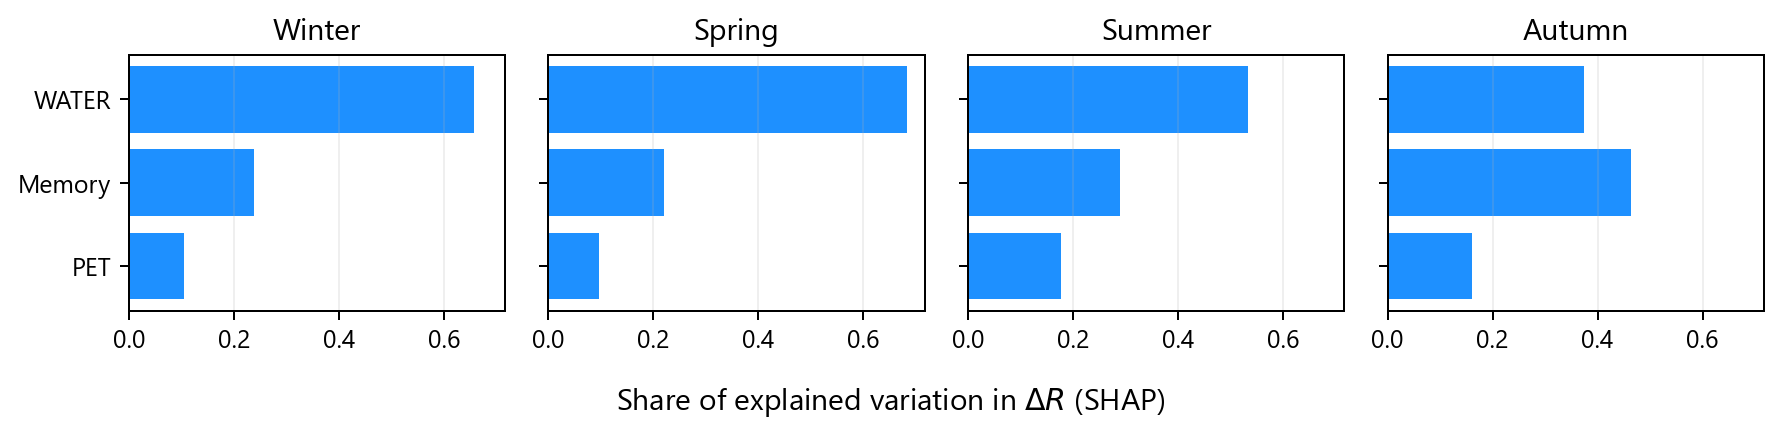

In [ ]:

# feature_names = ['dPET', 'dP', 'dWA']
season_order = ['winter', 'spring', 'summer', 'autumn']  # adjust if your keys differ
bucket_order = ['PET', 'Memory', 'WATER']  # top → bottom in all panels


fig, axes = plt.subplots(1, 4, figsize=(10, 2.5), dpi=180, sharex=True)
axes = axes.ravel()

for i, season in enumerate(season_order):
    share_imp = seasonal_bucket_importance[season].copy()

    # set index to bucket and reorder rows to fixed order
    share_imp = (share_imp.set_index('bucket')
                            .loc[bucket_order]        # enforce same order
                            .reset_index())

    ax = axes[i]
    ax.barh(share_imp['bucket'], share_imp['share'],
            height=0.8, color='dodgerblue')
    ax.set_title(season.capitalize())
    ax.grid(alpha=0.2, axis='x')

    if i != 0:
        ax.set_yticklabels([])

fig.supxlabel('Share of explained variation in $\Delta R$ (SHAP)', y=0.05)
plt.tight_layout()
plt.show()